## Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge,Lasso 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os

### https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes
This dataset was used in the two notebooks, after deleting the 2 uncleaned csv files.

## Get all CSV files and combine them

In [2]:
# Get all CSV files in the folder
csv_files = glob.glob("cars/*.csv") 

dfs = [pd.read_csv(file).assign(brand=os.path.splitext(os.path.basename(file))[0]) for file in csv_files]

# Combine all DataFrames into one
df_combined = pd.concat(dfs, ignore_index=True)

print(df_combined.shape)  # Check total rows & columns
print(df_combined.head())  # Show first 5 rows


(108540, 11)
  model  year  price transmission  mileage fuelType    tax   mpg  engineSize  \
0    A1  2017  12500       Manual    15735   Petrol  150.0  55.4         1.4   
1    A6  2016  16500    Automatic    36203   Diesel   20.0  64.2         2.0   
2    A1  2016  11000       Manual    29946   Petrol   30.0  55.4         1.4   
3    A4  2017  16800    Automatic    25952   Diesel  145.0  67.3         2.0   
4    A3  2019  17300       Manual     1998   Petrol  145.0  49.6         1.0   

  brand  tax(£)  
0  audi     NaN  
1  audi     NaN  
2  audi     NaN  
3  audi     NaN  
4  audi     NaN  


# Removing outliers

In [3]:
# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_combined['price'].quantile(0.25)
Q3 = df_combined['price'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

# Define lower and upper bounds for filtering
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Original rows: {len(df_combined)}") 
# Filter out outliers
df_combined = df_combined[(df_combined['price'] >= lower_bound) & (df_combined['price'] <= upper_bound)]
print(f"Filtered rows: {len(df_combined)}")


Original rows: 108540
Filtered rows: 104642


## Dropping what's not important (or what's unclean)

In [4]:
df_combined = df_combined.drop("tax(£)", axis=1)
df_combined = df_combined.drop("tax", axis=1)
#df_combined = df_combined.drop("model", axis=1)
print(df_combined.shape)  # Check total rows & columns
print(df_combined.head())  # Show first 5 rows
print(df_combined.isnull().sum())  

(104642, 9)
  model  year  price transmission  mileage fuelType   mpg  engineSize brand
0    A1  2017  12500       Manual    15735   Petrol  55.4         1.4  audi
1    A6  2016  16500    Automatic    36203   Diesel  64.2         2.0  audi
2    A1  2016  11000       Manual    29946   Petrol  55.4         1.4  audi
3    A4  2017  16800    Automatic    25952   Diesel  67.3         2.0  audi
4    A3  2019  17300       Manual     1998   Petrol  49.6         1.0  audi
model              0
year               0
price              0
transmission       0
mileage            0
fuelType           0
mpg             9131
engineSize         0
brand              0
dtype: int64


## MPG did have null values, you can fill them with median or mean

In [5]:
# Create an imputer with median strategy
imputer = SimpleImputer(strategy="mean")

# Fit and transform only the 'mileage' column
df_combined["mpg"] = imputer.fit_transform(df_combined[["mpg"]])
print(df_combined.isnull().sum())  

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
mpg             0
engineSize      0
brand           0
dtype: int64


## Any categorical column can be hot encoded

In [6]:
# Load data (assuming df_combined is already read)
categorical_cols = ["model", "transmission", "fuelType","brand"]

# One-Hot Encoding (drop first category to avoid multicollinearity)
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded_data = encoder.fit_transform(df_combined[categorical_cols]) 

# Convert to DataFrame with proper column names
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

encoded_df.index = df_combined.index
# Drop original categorical columns and concatenate new encoded columns
df_combined = df_combined.drop(categorical_cols, axis=1)
df_combined = pd.concat([df_combined, encoded_df], axis=1)


df_combined["mpg_mileage"] = df_combined["mileage"]*df_combined["mpg"]
df_combined["mpg_mileage"] = df_combined["mileage"]*df_combined["mpg"]/100000
df_combined["engineSize_mpg"] = df_combined["engineSize"]* df_combined["mpg"]
print(df_combined.isnull().sum())  

year              0
price             0
mileage           0
mpg               0
engineSize        0
                 ..
brand_toyota      0
brand_vauxhall    0
brand_vw          0
mpg_mileage       0
engineSize_mpg    0
Length: 210, dtype: int64


## Car age is better than year and more descriptive

In [7]:
df_combined["car_age"] = 2025 - df_combined["year"]
df_combined = df_combined.drop("year", axis=1)  # Drop the original year column
print(df_combined.head())  # Show first 5 rows

   price  mileage   mpg  engineSize  model_ 2 Series  model_ 3 Series  \
0  12500    15735  55.4         1.4              0.0              0.0   
1  16500    36203  64.2         2.0              0.0              0.0   
2  11000    29946  55.4         1.4              0.0              0.0   
3  16800    25952  67.3         2.0              0.0              0.0   
4  17300     1998  49.6         1.0              0.0              0.0   

   model_ 4 Series  model_ 5 Series  model_ 6 Series  model_ 7 Series  ...  \
0              0.0              0.0              0.0              0.0  ...   
1              0.0              0.0              0.0              0.0  ...   
2              0.0              0.0              0.0              0.0  ...   
3              0.0              0.0              0.0              0.0  ...   
4              0.0              0.0              0.0              0.0  ...   

   brand_ford  brand_hyundi  brand_merc  brand_skoda  brand_toyota  \
0         0.0         

## Separate features (X) and target (y)

Mean price: 15690.204736148009


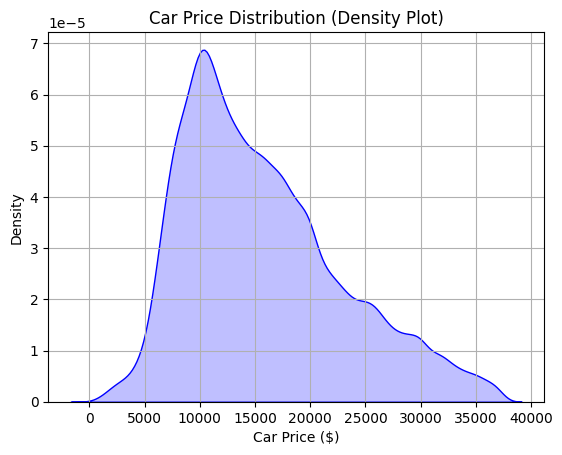

In [8]:
X = df_combined.drop("price", axis=1)  # Features
y = df_combined["price"]  # Target
print("Mean price:", y.mean())
y.median()


# Example data (replace with actual prices)
sns.kdeplot(df_combined["price"], fill=True, color='blue')

plt.xlabel("Car Price ($)")
plt.ylabel("Density")
plt.title("Car Price Distribution (Density Plot)")
plt.grid(True)
plt.show()

# Split data: 60% train, 20% validation, 20% test

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% val, 20% test

## Scaling the data (zero mean, unit variance)

In [10]:


# Select numerical columns to scale (excluding 'price' since it's the target variable)
numerical_cols = ["mileage", "mpg", "engineSize", "mpg_mileage", "engineSize_mpg", "car_age"]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [11]:
# # Select the top 10 features
# selector = SelectKBest(score_func=f_regression, k=10)
# X_train = selector.fit_transform(X_train, y_train)

# # Apply the same transformation to validation and test sets
# X_val = selector.transform(X_val)
# X_test = selector.transform(X_test)

# scaler = StandardScaler()

# X_train_scaled= scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled= scaler.transform(X_test)

The cell above will fix the very huge error by the linear regression model, but it won't be better after regularization.

## Train Linear Regression Model

In [12]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict
y_val_pred = lr_model.predict(X_val_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

# Calculate MSE
val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Linear Regression - Validation MSE: {val_mse:.2f}")
print(f"Linear Regression - Test MSE: {test_mse:.2f}")


Linear Regression - Validation MSE: 7010318630337560673517568.00
Linear Regression - Test MSE: 867861889311886826012672.00


## L1 Regularization

In [13]:
lasso_model = Lasso(alpha=1.0,max_iter=10000)  # Alpha = Regularization Strength
lasso_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_val_lasso = lasso_model.predict(X_val_scaled)
y_test_lasso = lasso_model.predict(X_test_scaled)

lasso_val_mse = mean_squared_error(y_val, y_val_lasso)
lasso_test_mse = mean_squared_error(y_test, y_test_lasso)

print(f"Ridge Regression - Validation MSE: {lasso_val_mse:.2f}")
print(f"Ridge Regression - Test MSE: {lasso_test_mse:.2f}")


Ridge Regression - Validation MSE: 6868878.94
Ridge Regression - Test MSE: 6434935.16


## L2 Regularization

In [14]:
ridge_model = Ridge(alpha=1.0)  # Alpha = Regularization Strength
ridge_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_val_ridge = ridge_model.predict(X_val_scaled)
y_test_ridge = ridge_model.predict(X_test_scaled)

ridge_val_mse = mean_squared_error(y_val, y_val_ridge)
ridge_test_mse = mean_squared_error(y_test, y_test_ridge)

print(f"Ridge Regression - Validation MSE: {ridge_val_mse:.2f}")
print(f"Ridge Regression - Test MSE: {ridge_test_mse:.2f}")


Ridge Regression - Validation MSE: 6712061.38
Ridge Regression - Test MSE: 6297298.19


In [15]:
math.sqrt(lasso_test_mse)/y.median()

0.17745487220630937

In [16]:
math.sqrt(ridge_test_mse)/y.median()

0.17554682119412016

In [17]:
print(df_combined.describe())

               price        mileage            mpg     engineSize  \
count  104642.000000  104642.000000  104642.000000  104642.000000   
mean    15690.204736   23641.708989      55.818999       1.615084   
std      7232.000105   21272.248072      15.002283       0.491574   
min       450.000000       1.000000       0.300000       0.000000   
25%      9999.000000    8119.250000      47.900000       1.200000   
50%     14295.000000   18016.000000      55.818999       1.500000   
75%     19990.000000   32942.750000      61.700000       2.000000   
max     37000.000000  323000.000000     470.800000       6.300000   

       model_ 2 Series  model_ 3 Series  model_ 4 Series  model_ 5 Series  \
count    104642.000000     104642.00000    104642.000000    104642.000000   
mean          0.011726          0.02263         0.009308         0.009719   
std           0.107649          0.14872         0.096028         0.098104   
min           0.000000          0.00000         0.000000         0.000

use describe to check if data could be cleaned more, and the answer is yes, this data could be cleaned more.